In [1]:
## Program to ivestigate characteristics of AF-Multimer models from DDI prediction project
## Created by: Joelle Strom
## Last updated: 13.05.2024

# Import libraries
import db_utils_sqlalchemy
import MySQLdb
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Establish connection to MySQL server
engine = db_utils_sqlalchemy.get_connection()

/tmp/ipykernel_2362/3783416315.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


2024-05-14 13:38:11,071 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-05-14 13:38:11,073 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-05-14 13:38:11,085 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-05-14 13:38:11,087 INFO sqlalchemy.engine.Engine [raw sql] ()
2024-05-14 13:38:11,107 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-05-14 13:38:11,108 INFO sqlalchemy.engine.Engine [raw sql] ()


In [2]:
from sqlalchemy import text
# Import table of predictions along with merged characteristics from Burke et al. analysis
# Selecting only those interactions with a high-confidence AlphaFold model from fragment approach (high_conf_AF_model=1)
query = text("select * from johanna_db.HuRI_DDI_cytoscape_edges where DDI_type!='PF00038_PF00038' and high_conf_AF_model=1")
df = pd.read_sql(query, con=engine)

2024-05-14 13:38:15,051 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-05-14 13:38:15,057 INFO sqlalchemy.engine.Engine select * from johanna_db.HuRI_DDI_cytoscape_edges where DDI_type!='PF00038_PF00038' and high_conf_AF_model=1
2024-05-14 13:38:15,059 INFO sqlalchemy.engine.Engine [generated in 0.00804s] ()
2024-05-14 13:38:15,101 INFO sqlalchemy.engine.Engine ROLLBACK


In [3]:
print(df)

    ensembl_gene_id1 ensembl_gene_id2 uniprot_ac1  symbol1 uniprot_ac2  \
0    ENSG00000002330  ENSG00000129473      Q92934      BAD      Q92843   
1    ENSG00000171552  ENSG00000002330      Q07817   BCL2L1      Q92934   
2    ENSG00000164109  ENSG00000002822      Q13257   MAD2L1      Q9Y6D9   
3    ENSG00000104388  ENSG00000003147      P61019    RAB2A      Q05084   
4    ENSG00000129472  ENSG00000003147      Q8WUD1    RAB2B      Q05084   
..               ...              ...         ...      ...         ...   
642  ENSG00000244734  ENSG00000206172      P68871      HBB      P69905   
643  ENSG00000244734  ENSG00000206177      P68871      HBB      Q6B0K9   
644  ENSG00000231989  ENSG00000213639      Q6NXS1  PPP1R2B      P62140   
645  ENSG00000272047  ENSG00000213780      Q6ZYL4   GTF2H5      Q92759   
646  ENSG00000272047  ENSG00000213780      Q6ZYL4   GTF2H5      Q92759   

    symbol2         DDI_type domain_id1 domain_id2  num_DDI_matches  ...  \
0    BCL2L2  PF00452_PF10514    PF1

In [4]:
#Sort by model confidence and drop everything but the best model for an interaction
df.sort_values(by='model_confidence', ascending=False, inplace=True)
df.drop_duplicates(subset=['ensembl_gene_id1','ensembl_gene_id2'], keep='first', inplace=True, ignore_index=True)
print(df)

    ensembl_gene_id1 ensembl_gene_id2 uniprot_ac1 symbol1 uniprot_ac2 symbol2  \
0    ENSG00000134201  ENSG00000213366      P46439   GSTM5      P28161   GSTM2   
1    ENSG00000144744  ENSG00000159593      Q8TBC4    UBA3      Q13564    NAE1   
2    ENSG00000006125  ENSG00000161203      P63010   AP2B1      Q96CW1   AP2M1   
3    ENSG00000006125  ENSG00000129354      P63010   AP2B1      Q9Y6Q5   AP1M2   
4    ENSG00000134201  ENSG00000134202      P46439   GSTM5      P21266   GSTM3   
..               ...              ...         ...     ...         ...     ...   
599  ENSG00000162521  ENSG00000182979      Q09028   RBBP4      Q13330    MTA1   
600  ENSG00000213654  ENSG00000127955      Q9Y4H4   GPSM3      P63096   GNAI1   
601  ENSG00000135018  ENSG00000168591      Q9UMX0  UBQLN1      Q71RG4   TMUB2   
602  ENSG00000146618  ENSG00000233608      Q96RJ6  FERD3L      Q8WVJ9  TWIST2   
603  ENSG00000125447  ENSG00000113595      Q9NZ52    GGA3      P36406  TRIM23   

            DDI_type domain

In [5]:
# Create indicator for plot grouping
# Looking for difference in protein length and disorder fraction between interactions with high-confidence full-length model and low-confidence full-length model
# Using Burke et al. (2023) full-length models, where pDockQ is the measure of model confidence - choose 0.5 as cut-off
df.loc[df['pDockq_Burke'] > 0.5,'burkehighconf'] = '> 0.5'
df['burkehighconf'] = df['burkehighconf'].fillna('< 0.5')

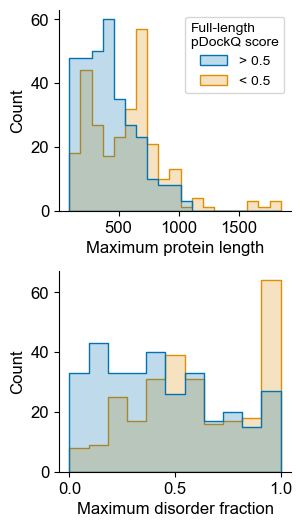

In [6]:
# Global plot formatting
plt.rcParams['axes.spines.top'] = False # remove top spine
plt.rcParams['axes.spines.right'] = False # remove right spine
plt.rcParams['pdf.fonttype'] = 42 # Set the fonttype to export fonts as font files
plt.rcParams['font.family'] = 'Arial'
sns.set_palette("colorblind")
global_fontsize = 12
figsize = (3,3)
legend_fontsize = 8
bbox_to_anchor =(1.0, 1.0)
global_color = 'tab:grey'

# Plot protein characteristics
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(3,6))
hist1 = sns.histplot(df, x="max_protlen", hue="burkehighconf", element="step", ax=ax1)
ax1.set_title(None)
ax1.set_xlabel('Maximum protein length', fontsize=global_fontsize)
ax1.set_ylabel('Count', fontsize=global_fontsize)
ax1.tick_params(axis='both', labelsize= global_fontsize)
hist1.legend_.set(title='Full-length\npDockQ score', bbox_to_anchor=(1.0,1.0))
sns.histplot(df, x="max_disfrac", hue="burkehighconf", element="step", ax=ax2)
ax2.set_title(None)
ax2.set_xlabel('Maximum disorder fraction', fontsize=global_fontsize)
ax2.set_ylabel('Count', fontsize=global_fontsize)
ax2.tick_params(axis='both', labelsize= global_fontsize)
ax2.legend([],[], frameon=False)

plt.subplots_adjust(hspace=0.3)

save_path = '/mnt/c/Users/stromjoe/Documents/'
fig.savefig(f'{save_path}prot_char_AfModelSubset_pdockqCompare.pdf',
           transparent=True,bbox_inches='tight')
fig.savefig(f'{save_path}prot_char_AfModelSubset_pdockqCompare.jpeg',dpi=300,
           transparent=True,bbox_inches='tight')


In [14]:
# Compute statistical significance of the observed differences in distributions above
from scipy.stats import mannwhitneyu

print(mannwhitneyu(x=list(df.loc[df['burkehighconf'] == '> 0.5'].max_protlen), y=list(df.loc[df['burkehighconf'] == '< 0.5'].max_protlen), nan_policy='omit')) # < 0.0001
print(mannwhitneyu(x=list(df.loc[df['burkehighconf'] == '> 0.5'].max_disfrac), y=list(df.loc[df['burkehighconf'] == '< 0.5'].max_disfrac), nan_policy='omit')) # < 0.0001

MannwhitneyuResult(statistic=31307.5, pvalue=1.2688150890549691e-09)
MannwhitneyuResult(statistic=30194.0, pvalue=4.003990197322491e-11)
